In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df = pd.read_csv('gene_expression.csv')

In [31]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


<AxesSubplot: xlabel='Cancer Present', ylabel='count'>

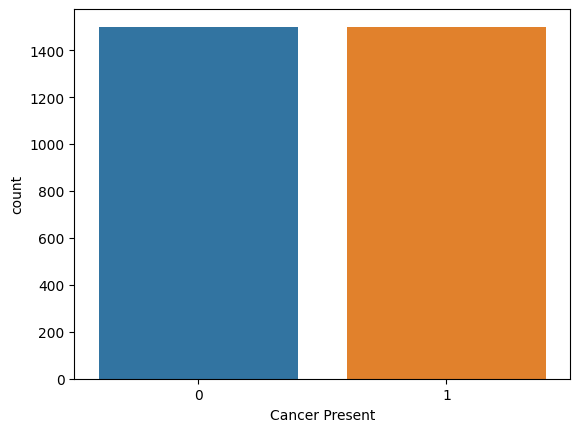

In [33]:
# check data balance between different classes
sns.countplot(data=df , x="Cancer Present")

In [34]:
df['Cancer Present'].value_counts()

1    1500
0    1500
Name: Cancer Present, dtype: int64

<AxesSubplot: xlabel='Gene One', ylabel='Gene Two'>

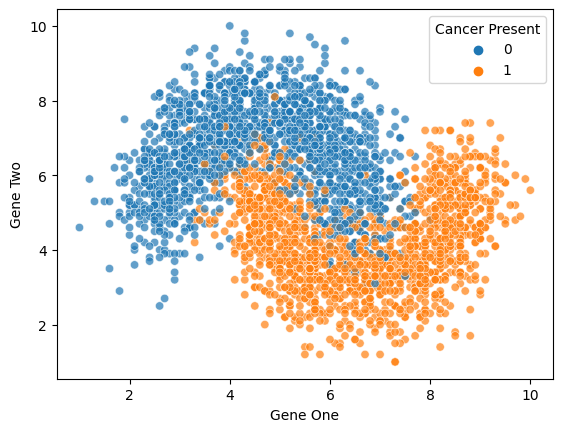

In [35]:
# Check how is the separation of our data based Cancer Presentation y ( label column)
sns.scatterplot(data=df,
                x="Gene One",
                y="Gene Two",
                hue="Cancer Present",
                alpha= .7)

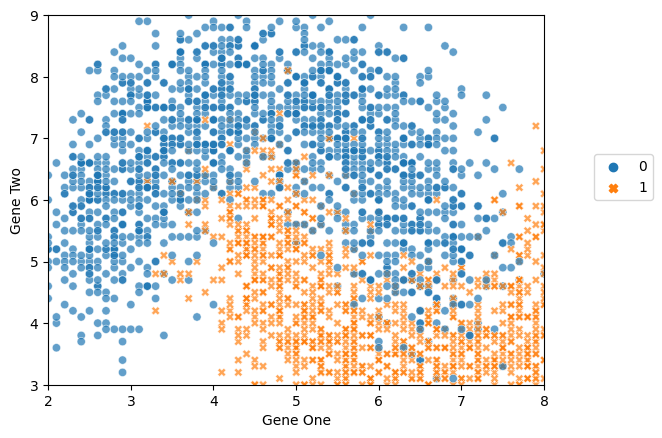

In [36]:
# We noticed there are some interactions between 2 classes let's discover them 
sns.scatterplot(data=df,
                x="Gene One",
                y="Gene Two",
                hue="Cancer Present",
                style="Cancer Present",
                alpha= .7)
plt.xlim(2,8)
plt.ylim(3,9)
plt.legend(loc=(1.1,0.5))

In [37]:
# ==>  Based on previous plotting we can see there is a good interactions and we expect accuracy from 90-96%
# Which means we can invest time to start creation of ML model

In [38]:
# Divide our data in X ,y 

X = df.drop("Cancer Present", axis=1)
y = df["Cancer Present"]

In [39]:
len(X)

3000

In [53]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [54]:
# Scaling is MUST in Distance algorithms 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [55]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [56]:
# Build and train the classifier (KNN)
from sklearn.neighbors import KNeighborsClassifier
help(KNeighborsClassifier) # n_neighbors is K in theory 

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'}, callable or None, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighb

In [57]:
knn_1_model = KNeighborsClassifier(n_neighbors=1)
knn_1_model.fit(scaled_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [58]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
y_pred_1 = knn_1_model.predict(scaled_X_test)
print(classification_report(y_test,y_pred_1))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       292
           1       0.89      0.93      0.91       308

    accuracy                           0.91       600
   macro avg       0.91      0.90      0.90       600
weighted avg       0.91      0.91      0.90       600



In [59]:
confusion_matrix(y_test,y_pred_1)

array([[257,  35],
       [ 22, 286]], dtype=int64)

In [60]:
accuracy_score(y_test,y_pred_1)

0.905

In [61]:
# How to find best K ( n_neighbors) value 
### First method Elbow method :
#### based on min error rate we grab the related K 
test_error_rates = []
for k in range(1,30):
    # create and train the model
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train)
    # Create related y_pred
    y_pred = knn_model.predict(scaled_X_test)
    # Calculate error_rate based on 1- accuracy_score
    error_rate = 1-accuracy_score(y_test,y_pred)
    # append this to our test_error_rates 
    test_error_rates.append(error_rate)

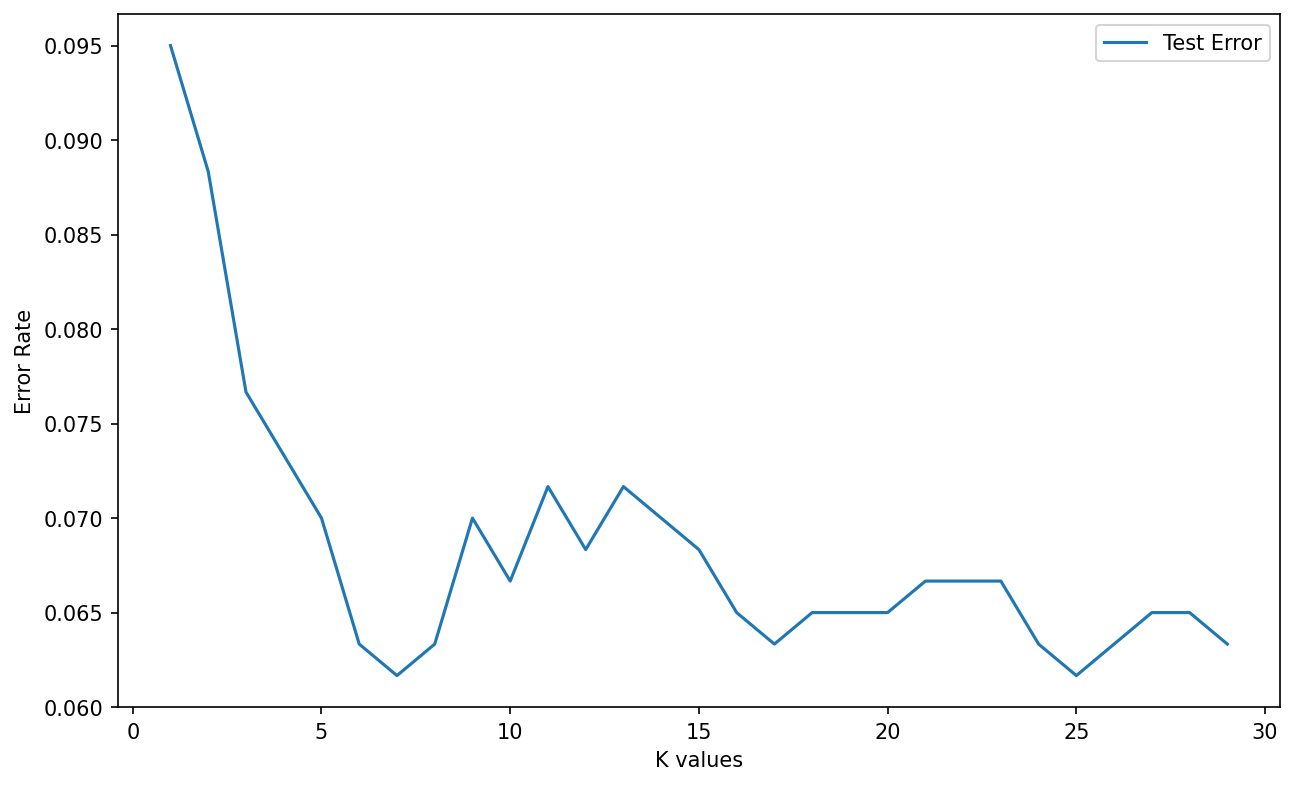

In [62]:
# Let's plot the elbow method based on error_rates
plt.figure(figsize=(10,6), dpi=150)
plt.plot(range(1,30),test_error_rates,label = "Test Error")
plt.ylabel("Error Rate")
plt.xlabel("K values")
plt.legend()

In [63]:
test_error_rates_df = pd.DataFrame(test_error_rates,columns=["Error rate"])

In [64]:
test_error_rates_df.nsmallest(1,"Error rate")

,Error rate
6,0.061667


In [65]:
test_error_rates_df.nsmallest(5,"Error rate")

,Error rate
6,0.061667
24,0.061667
5,0.063333
7,0.063333
16,0.063333


In [66]:
# Based on Elbow we found the min error_rate can be based on K = 7 :) 

In [67]:
### Let's discover how we build Pipeline and check with GridSearchCV what is best K.

In [68]:
from sklearn.pipeline import Pipeline
help(Pipeline)

Help on class Pipeline in module sklearn.pipeline:

class Pipeline(sklearn.utils.metaestimators._BaseComposition)
 |  Pipeline(steps, *, memory=None, verbose=False)
 |  
 |  Pipeline of transforms with a final estimator.
 |  
 |  Sequentially apply a list of transforms and a final estimator.
 |  Intermediate steps of the pipeline must be 'transforms', that is, they
 |  must implement `fit` and `transform` methods.
 |  The final estimator only needs to implement `fit`.
 |  The transformers in the pipeline can be cached using ``memory`` argument.
 |  
 |  The purpose of the pipeline is to assemble several steps that can be
 |  cross-validated together while setting different parameters. For this, it
 |  enables setting parameters of the various steps using their names and the
 |  parameter name separated by a `'__'`, as in the example below. A step's
 |  estimator may be replaced entirely by setting the parameter with its name
 |  to another estimator, or a transformer removed by setting

In [ ]:
## PIPELINE = ["Operation_1" --> "Operation_2" --> "Operation_3" .... ]
### Design for pipeline : is the chain of operations 
### Design for parameter or Hyper_parameter that we send to this pipe_line

In [ ]:
# in our project we need to use GridSearchCV to find best K ( n_neighbors ) value for our data 
## and to do this pipeline we need scaler --> Knn model
## then we need to prepare param_grid in right way to make pipeline class object understand what we need in GSCV

In [70]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

In [71]:
#### Design for pipeline : is the chain of operations 
operations = [('scaler',scaler),('knn',knn)] 
# operations is list of tuples where each tuple has "operation name and operation (SKLEARN) object"
pipe_std_knn_class = Pipeline(operations)

In [72]:
type(pipe_std_knn_class)

sklearn.pipeline.Pipeline

In [ ]:
# Design for parameter or Hyper_parameter that we send to this pipe_line
from sklearn.model_selection import GridSearchCV
help(GridSearchCV)

In [75]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [76]:
scaler.get_params().keys()

dict_keys(['copy', 'with_mean', 'with_std'])

In [77]:
# Our Target is to find bet K for our data frame
k_values = list(range(1,30)) # [1,2,...30]
grid_param = {"knn__n_neighbors":k_values} # Key must be : "operation_name"+ __ +"Hyper_parameter_name" , where __ is double under scores

In [80]:
knn_best_model = GridSearchCV(pipe_std_knn_class, # Estimator as pipeline start with scaling and end with KNN model
                              cv=10, # divide our data into 10 chunks
                              scoring="accuracy", # aiming to get best accuracy
                              param_grid=grid_param) # a dictionary of 
                                                    # hyper parameters that formed related key with operation 
                                                    #name and original hyper-parameter name 

In [81]:
# train model: 
knn_best_model.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [82]:
type(knn_best_model)

sklearn.model_selection._search.GridSearchCV

In [83]:
knn_best_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=24))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=24),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 24,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [84]:
y_pred_cv = knn_best_model.predict(X_test)

In [86]:
print(classification_report(y_test,y_pred_cv))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       292
           1       0.94      0.94      0.94       308

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



In [87]:
knn_best_model.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [88]:
cv_results_df = pd.DataFrame(knn_best_model.cv_results_,columns=knn_best_model.cv_results_.keys())
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004466,0.001929,0.006417,0.001724,1,{'knn__n_neighbors': 1},0.904167,0.954167,0.912500,0.895833,0.850000,0.904167,0.895833,0.916667,0.870833,0.916667,0.902083,0.026500,29
1,0.004098,0.001098,0.006283,0.001520,2,{'knn__n_neighbors': 2},0.920833,0.904167,0.920833,0.904167,0.879167,0.879167,0.916667,0.929167,0.891667,0.916667,0.906250,0.016899,28
2,0.005423,0.001537,0.007048,0.002025,3,{'knn__n_neighbors': 3},0.941667,0.925000,0.937500,0.912500,0.895833,0.912500,0.929167,0.929167,0.904167,0.916667,0.920417,0.013876,27
3,0.005027,0.002009,0.006270,0.001938,4,{'knn__n_neighbors': 4},0.950000,0.929167,0.941667,0.925000,0.891667,0.895833,0.945833,0.925000,0.912500,0.912500,0.922917,0.018934,26
4,0.005150,0.000962,0.007106,0.001515,5,{'knn__n_neighbors': 5},0.937500,0.941667,0.941667,0.933333,0.912500,0.929167,0.933333,0.937500,0.904167,0.941667,0.931250,0.012255,20
5,0.004612,0.001474,0.007431,0.002111,6,{'knn__n_neighbors': 6},0.937500,0.941667,0.937500,0.929167,0.895833,0.925000,0.945833,0.941667,0.908333,0.925000,0.928750,0.015190,25
6,0.005094,0.000724,0.007446,0.001359,7,{'knn__n_neighbors': 7},0.937500,0.937500,0.937500,0.937500,0.895833,0.925000,0.937500,0.945833,0.916667,0.933333,0.930417,0.013826,23
7,0.004713,0.001118,0.006559,0.000937,8,{'knn__n_neighbors': 8},0.937500,0.945833,0.941667,0.937500,0.900000,0.925000,0.937500,0.945833,0.912500,0.929167,0.931250,0.014222,20
8,0.004238,0.000808,0.005880,0.000550,9,{'knn__n_neighbors': 9},0.937500,0.941667,0.941667,0.941667,0.904167,0.929167,0.937500,0.945833,0.925000,0.933333,0.933750,0.011555,10
9,0.003808,0.000618,0.005663,0.000974,10,{'knn__n_neighbors': 10},0.937500,0.950000,0.937500,0.941667,0.900000,0.929167,0.941667,0.941667,0.925000,0.925000,0.932917,0.013366,14


In [89]:
# Final Model

knn_full_model = knn_best_model.fit(X,y)

In [90]:
from joblib import dump, load
dump(knn_full_model,"knn_gene_expressions_240220.joblib")

['knn_gene_expressions_240220.joblib']

In [91]:
loaded_model = load("knn_gene_expressions_240220.joblib")

In [92]:
single_sample = X_test.iloc[40]

In [93]:
single_sample

Gene One    9.1
Gene Two    6.0
Name: 2487, dtype: float64

In [95]:
loaded_model.predict(single_sample.values.reshape(1,-1))

c:\Users\engam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [96]:
loaded_model.predict_proba(single_sample.values.reshape(1,-1))

c:\Users\engam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0., 1.]])